In [183]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from skimage.feature import graycoprops, graycomatrix


In [184]:
def load_images(dir_name):

    img_list = []

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    for item in os.listdir(dir_name):

        img_path = os.path.join(dir_name, item)
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.GaussianBlur(img, (5,5), 1)

        img = clahe.apply(img)
        
        img_list.append(img)

    
    return img_list

def img_to_array(img):
    
    
    img = np.asarray(img)
    return img
  
def find_edges(img):

    v = np.median(img)
    sigma = 0.33

    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(max(0, (1.0 + sigma) * v))

    img = cv2.Canny(img, lower, upper)
    return img


In [185]:
image_list = load_images("./train/Impacted Fracture")
print(len(image_list))


309


<function matplotlib.pyplot.show(close=None, block=None)>

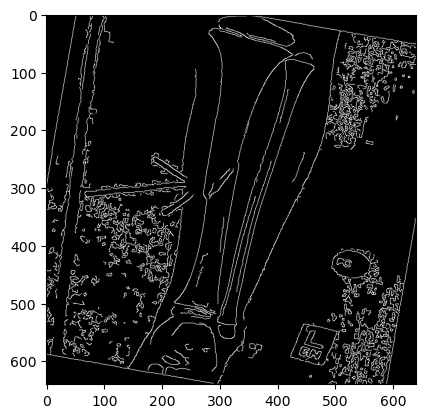

In [186]:

for i, img in enumerate(image_list):
    img = find_edges(img)
    image_list[i] = img


plt.imshow(image_list[0], cmap='gray')
#plt.imshow(img_arr[30])
plt.show

In [187]:


feature_list = []

distances = [1,3,5,9]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2]

properties = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast']

# need to add more distances (1,3,5,9)
for n, img in enumerate(image_list):
    glcm = graycomatrix(img, distances, angles , levels=256, normed=True)
    feature_row = {}

    for prop in properties:
        prop_values = graycoprops(glcm, prop)   
        for i, dist in enumerate(distances):
            for j, angle in enumerate(angles): 
                feature_name = f"{prop}_d{dist}_a{int(np.degrees(angle))}"
                feature_row[feature_name] = prop_values[i, j]

    feature_list.append(feature_row)

In [188]:
df = pd.DataFrame(feature_list)
df.head()

,energy_d1_a0,energy_d1_a45,energy_d1_a90,energy_d1_a135,energy_d1_a180,energy_d1_a225,energy_d1_a270,energy_d3_a0,energy_d3_a45,energy_d3_a90,...,contrast_d5_a180,contrast_d5_a225,contrast_d5_a270,contrast_d9_a0,contrast_d9_a45,contrast_d9_a90,contrast_d9_a135,contrast_d9_a180,contrast_d9_a225,contrast_d9_a270
0,0.906108,0.898242,0.913065,0.901162,0.906108,0.898242,0.913065,0.897057,0.894654,0.900227,...,6427.938853,6504.814881,6235.775898,6664.965890,6621.466715,6585.906671,6611.760429,6664.965890,6621.466715,6585.906671
1,0.849575,0.837170,0.859231,0.838581,0.849575,0.837170,0.859231,0.840858,0.833984,0.845836,...,9612.147822,9993.854575,9112.780143,9922.817576,10057.006737,9500.309652,10096.155425,9922.817576,10057.006737,9500.309652
2,0.886889,0.878018,0.895949,0.879049,0.886889,0.878018,0.895949,0.879161,0.875412,0.884422,...,7430.834277,7580.912914,6874.025714,7705.778093,7709.703176,7265.719344,7747.072379,7705.778093,7709.703176,7265.719344
3,0.962959,0.959603,0.969222,0.962211,0.962959,0.959603,0.969222,0.962446,0.960901,0.962439,...,2226.274237,2354.105109,2433.957431,2424.912094,2449.219566,2486.903539,2427.218651,2424.912094,2449.219566,2486.903539
4,0.978326,0.976020,0.981798,0.976397,0.978326,0.976020,0.981798,0.979014,0.976946,0.978842,...,1146.897638,1406.450805,1230.578925,1310.193208,1436.045052,1435.303214,1396.572821,1310.193208,1436.045052,1435.303214


In [189]:
df =df.iloc[:60, :]
print(df.shape)

(60, 140)


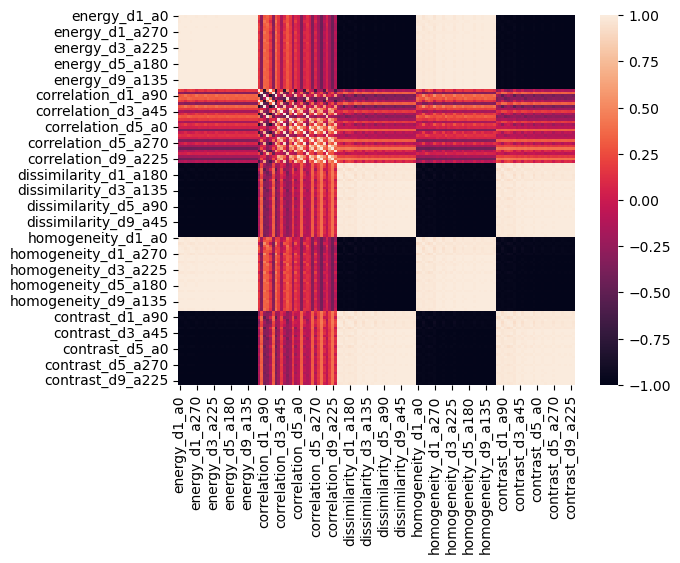

In [190]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

corr_matrix = df.corr()
sns.heatmap(corr_matrix)
plt.show()

In [191]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

pca = PCA()
pca_features = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(pca_features, columns=[f"PC{i+1}" for i in range(pca.n_components_)])

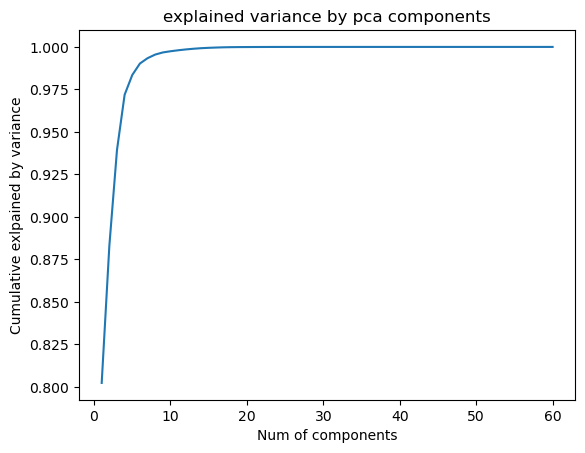

In [192]:
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.xlabel("Num of components")
plt.ylabel('Cumulative exlpained by variance')
plt.title('explained variance by pca components')
plt.show()

In [193]:
#want to pick where 95% is explained

cumulative_var = pca.explained_variance_ratio_.cumsum()
n_components = 0

for i, var in enumerate(cumulative_var):
    if var >= 0.95:
        n_components = i + 1
        break

pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(scaled_features)

pca_columns = [f"PC{i+1}" for i in range(n_components)]
pca_df_oblique= pd.DataFrame(reduced_features, columns=pca_columns)

pca_df_oblique.head()

,PC1,PC2,PC3,PC4
0,-6.679291,-0.359146,0.429577,0.279313
1,-20.637240,2.059093,-0.012032,1.711712
2,-10.997796,2.164139,0.538540,0.932340
3,9.218322,4.854970,4.453099,1.971337
4,13.335838,9.078034,6.706153,2.423530


In [194]:
#309 rows 
image_list_2 = load_images("./train/Intra-articular fracture")
print(len(image_list_2))

63


<function matplotlib.pyplot.show(close=None, block=None)>

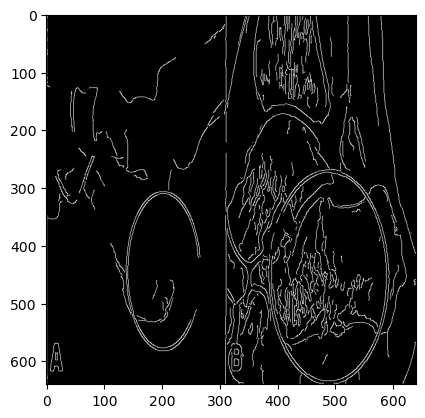

In [195]:
for i, img in enumerate(image_list_2):
    img = find_edges(img)
    image_list_2[i] = img


plt.imshow(image_list_2[0], cmap='gray')
#plt.imshow(img_arr[30])
plt.show

In [196]:
def get_features(image_list):

    feature_list = []

    distances = [1,3,5,9]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2]

    properties = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast']

    # need to add more distances (1,3,5,9)
    for n, img in enumerate(image_list):
        glcm = graycomatrix(img, distances, angles , levels=256, normed=True)
        feature_row = {}

        for prop in properties:
            prop_values = graycoprops(glcm, prop)   
            for i, dist in enumerate(distances):
                for j, angle in enumerate(angles): 
                    feature_name = f"{prop}_d{dist}_a{int(np.degrees(angle))}"
                    feature_row[feature_name] = prop_values[i, j]

        feature_list.append(feature_row)
    return feature_list

In [197]:
features_2 = get_features(image_list_2)

In [198]:
df_2 = pd.DataFrame(features_2)
print(df_2.shape)

(63, 140)


In [199]:
df_2 = df_2.iloc[:60, :]
print(df_2.shape)

(60, 140)


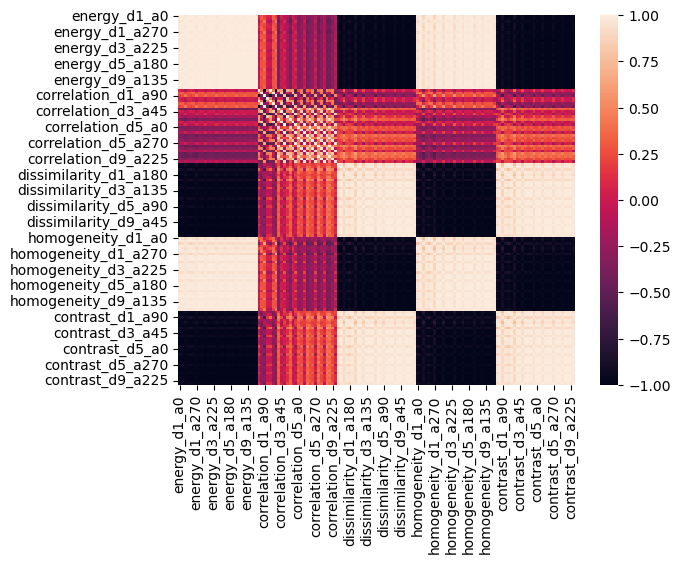

In [200]:
corr_matrix_2 = df_2.corr()
sns.heatmap(corr_matrix_2)
plt.show()

In [239]:
scaler = StandardScaler()
scaled_features_2 = scaler.fit_transform(df_2)

pca = PCA()
pca_features_2 = pca.fit_transform(scaled_features_2)

pca_df_2 = pd.DataFrame(pca_features_2,columns=[f"PC{i+1}" for i in range(pca.n_components_)] )

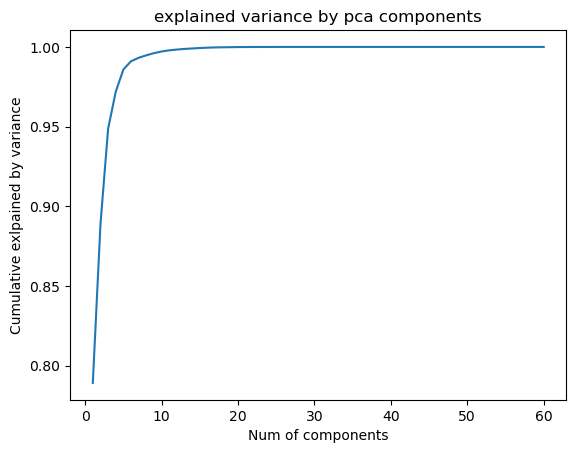

In [240]:
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.xlabel("Num of components")
plt.ylabel('Cumulative exlpained by variance')
plt.title('explained variance by pca components')
plt.show()

In [241]:
cumulative_var = pca.explained_variance_ratio_.cumsum()
n_components = 0

for i, var in enumerate(cumulative_var):
    if var >= 0.95:
        n_components = i + 1
        break

pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(scaled_features_2)

pca_columns = [f"PC{i+1}" for i in range(n_components)]
pca_df_iaf= pd.DataFrame(reduced_features, columns=pca_columns)

pca_df_iaf.head()

,PC1,PC2,PC3,PC4
0,-0.264941,-2.513569,0.289380,1.405694
1,6.316452,0.014092,-0.219268,1.772730
2,4.875142,1.851732,-0.799774,3.643423
3,2.233575,-2.455866,-1.947776,-0.751886
4,0.512991,-0.537912,-3.359541,-1.537358


In [242]:
print(pca_df_oblique.shape)
print(pca_df_iaf.shape)

(60, 5)
(60, 4)


In [243]:
#add target column to both 
# 0 is oblique
# 1 is iaf

pca_df_oblique['target'] = 0
pca_df_iaf['target'] = 1

print(pca_df_oblique.shape)
print(pca_df_iaf.shape)

(60, 5)
(60, 5)


In [244]:
df_combined = pd.concat([pca_df_oblique, pca_df_iaf], axis=0)

# Classification

In [246]:
image_list_test_1 = load_images("./test/Oblique fracture")
image_list_test_2 = load_images("./test/Intra-articular fracture")

print(len(image_list_test_1))
print(len(image_list_test_2))

23
67


In [247]:
image_list_test_1 = image_list_test_1[:23]
image_list_test_2 = image_list_test_2[:23]

print(len(image_list_test_1))
print(len(image_list_test_2))

23
23


<function matplotlib.pyplot.show(close=None, block=None)>

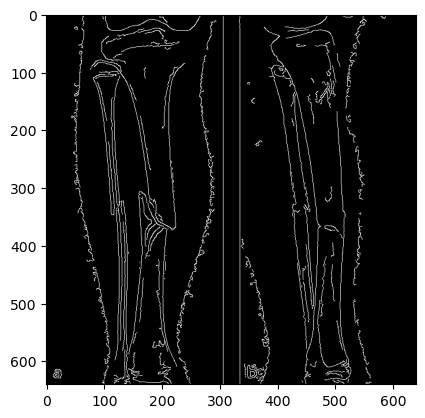

In [248]:
for i, img in enumerate(image_list_test_1):
    img = find_edges(img)
    image_list_test_1[i] = img


plt.imshow(image_list_test_1[1], cmap='gray')
#plt.imshow(img_arr[30])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

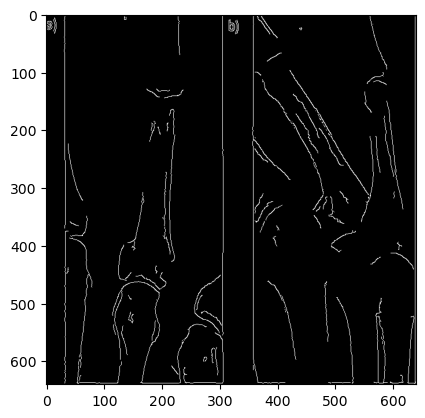

In [249]:
for i, img in enumerate(image_list_test_2):
    img = find_edges(img)
    image_list_test_2[i] = img


plt.imshow(image_list_test_2[0], cmap='gray')
#plt.imshow(img_arr[30])
plt.show

In [223]:
features_test_1 = get_features(image_list_test_1)


In [227]:
df_test_1 = pd.DataFrame(features_test_1)
print(df_test_1.shape)

(23, 140)


In [214]:
features_test_2 = get_features(image_list_test_2)

In [228]:
df_test_2 = pd.DataFrame(features_test_2)
print(df_test_2.shape)

(23, 140)


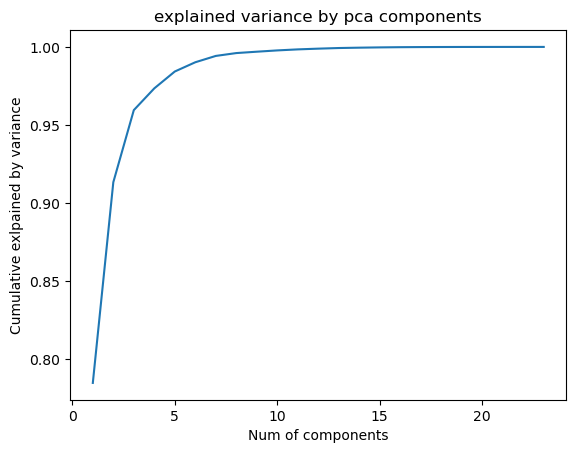

In [260]:
scaler = StandardScaler()
scaled_features_test_1 = scaler.fit_transform(df_test_1)

pca = PCA()
pca_features_test_1 = pca.fit_transform(scaled_features_test_1)

pca_df_test_1 = pd.DataFrame(pca_features_test_1,columns=[f"PC{i+1}" for i in range(pca.n_components_)] )

plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.xlabel("Num of components")
plt.ylabel('Cumulative exlpained by variance')
plt.title('explained variance by pca components')
plt.show()

In [261]:
cumulative_var = pca.explained_variance_ratio_.cumsum()
n_components = 0

for i, var in enumerate(cumulative_var):
    if var >= 0.97:
        n_components = i + 1
        break

pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(scaled_features_test_1)

pca_columns = [f"PC{i+1}" for i in range(n_components)]
pca_df_test_1= pd.DataFrame(reduced_features, columns=pca_columns)

pca_df_test_1.head()

,PC1,PC2,PC3,PC4
0,-1.510597,-0.617886,1.137445,2.144021
1,2.577693,-3.099393,-2.695529,0.330935
2,-20.925719,-1.576829,-1.136844,-1.841435
3,13.033870,4.035601,-5.673992,-0.385688
4,17.481153,-0.480135,5.953759,1.440715


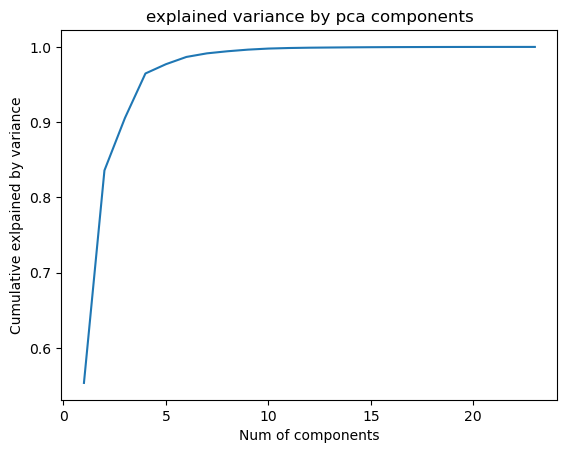

In [262]:
scaler = StandardScaler()
scaled_features_test_2 = scaler.fit_transform(df_test_2)

pca = PCA()
pca_features_test_2 = pca.fit_transform(scaled_features_test_2)

pca_df_test_2 = pd.DataFrame(pca_features_test_2,columns=[f"PC{i+1}" for i in range(pca.n_components_)] )

plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.xlabel("Num of components")
plt.ylabel('Cumulative exlpained by variance')
plt.title('explained variance by pca components')
plt.show()

In [264]:
cumulative_var = pca.explained_variance_ratio_.cumsum()
n_components = 0

for i, var in enumerate(cumulative_var):
    if var >= 0.95:
        n_components = i + 1
        break

pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(scaled_features_test_2)

pca_columns = [f"PC{i+1}" for i in range(n_components)]
pca_df_test_2= pd.DataFrame(reduced_features, columns=pca_columns)

pca_df_test_2.head()

,PC1,PC2,PC3,PC4
0,-5.014581,5.799770,-2.529225,5.199317
1,-2.041773,-1.945031,-2.213432,0.268352
2,-2.108527,-4.604451,-2.369906,1.875920
3,-9.949938,1.588267,-0.284788,-1.109517
4,11.858221,-0.934688,-6.921152,2.913667


In [265]:
pca_df_test_1['target'] = 0
pca_df_test_2['target'] = 1
print(pca_df_test_1.shape)
print(pca_df_test_2.shape)

(23, 5)
(23, 5)


In [266]:
#train test df
df_combined_test = pd.concat([pca_df_oblique, pca_df_iaf], axis=0)

In [293]:
#df_combined -> train
#df_combined_test -> test

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score



In [284]:
x_train = df_combined.iloc[:, :4]
y_train = df_combined.iloc[:, 4:5]

x_test = df_combined_test.iloc[:, :4]
y_test = df_combined_test.iloc[:, 4:5]


In [285]:
gnb = GaussianNB()

In [286]:
gnb.fit(x_train, y_train)

GaussianNB()

In [295]:
y_pred = gnb.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.525


In [298]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(x_train,y_train)

y_pred = knn.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(accuracy)
print(recall)

0.8666666666666667
0.8166666666666667


In [296]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=4)

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(accuracy)
print(recall)

1.0
1.0


In [299]:
from sklearn import svm

clf_svm = svm.SVC(kernel='rbf', C=10000)

clf_svm.fit(x_train,y_train)
y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(accuracy)
print(recall)

1.0
1.0
